In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from helper_functions import *

In [2]:
train = pd.read_csv("../Data/IPUMS/cleaned_ipums_data.csv")

In [3]:
train

,incwage,years_of_educ,potential_experience,non_white,sex
0,9.305651,16.000000,18.000000,0,1
1,10.545341,15.000000,23.000000,0,0
2,8.853665,13.000000,2.000000,0,0
3,7.863267,11.000000,0.000000,0,0
4,9.942708,12.000000,33.000000,1,0
...,...,...,...,...,...
197751,10.021271,16.000000,13.000000,0,0
197752,8.411833,16.000000,11.000000,0,1
197753,10.518673,17.737673,19.262327,0,0
197754,7.313220,15.000000,13.000000,0,1


Pick an arbitrary $\delta$ value.

In [4]:
delta = 0.001

Function to calculate the privacy metrics given training and synthetic data, for a given delta value.

Import the post-processed data (with wage converted to at least 1)

In [5]:
sXs_mnl = [pd.read_csv("../Data/IPUMS/Synthetic Datasets/gmm_and_mnl_" + str(i) + ".csv") for i in range(20)]
sXs_cart = [pd.read_csv("../Data/IPUMS/Synthetic Datasets/gmm_and_cart_" + str(i) + ".csv") for i in range(20)]
sXs_mostly = [pd.read_csv("../Data/IPUMS/Synthetic Datasets/mostly_" + str(i) + ".csv") for i in range(20)]

***

In [6]:
# def post_process(synthetic_datasets):
#     for Z in synthetic_datasets:
#         Z.loc[:,'incwage'] = np.where(Z.incwage < 1, 1, Z.incwage)

In [7]:
# post_process(sXs_mnl)
# post_process(sXs_cart)
# post_process(sXs_mostly)

In [8]:
pms_mnl = privacy_metrics(train_data=train, synthetic_datasets=sXs_mnl, type_of_synthetic="MNL", delta=delta)

C:\Users\Cameron\Box\Research Projects\optimized-sequential-synthesis\Code\helper_functions.py:123: RuntimeWarning: invalid value encountered in divide
  ratios_train = train_dists[:,1]/train_dists[:,-1]


In [9]:
# pms_ad_mnl = privacy_metrics(train_data=train, synthetic_datasets=ad_sXs_mnl, type_of_synthetic="AD-MNL", delta=delta)

In [10]:
pms_cart = privacy_metrics(train_data=train, synthetic_datasets=sXs_cart, type_of_synthetic="CART", delta=delta)

C:\Users\Cameron\Box\Research Projects\optimized-sequential-synthesis\Code\helper_functions.py:123: RuntimeWarning: invalid value encountered in divide
  ratios_train = train_dists[:,1]/train_dists[:,-1]


In [11]:
# pms_ad_cart = privacy_metrics(train_data=train, synthetic_datasets=ad_sXs_cart, type_of_synthetic="AD-CART", delta=delta)

In [12]:
pms_mostly = privacy_metrics(train_data=train, synthetic_datasets=sXs_mostly, type_of_synthetic="MOSTLY.AI", delta=delta)

C:\Users\Cameron\Box\Research Projects\optimized-sequential-synthesis\Code\helper_functions.py:123: RuntimeWarning: invalid value encountered in divide
  ratios_train = train_dists[:,1]/train_dists[:,-1]


In [13]:
# privacy_results = pd.concat([pms_mnl, pms_ad_mnl.iloc[1:,:], pms_cart.iloc[1:,:], pms_ad_cart.iloc[1:,:], pms_mostly.iloc[1:,:]]).reset_index(drop=True)

In [14]:
privacy_results = pd.concat([pms_mnl, pms_cart.iloc[1:,:], pms_mostly.iloc[1:,:]]).reset_index(drop=True)

In [15]:
privacy_results = privacy_results.melt(id_vars=["Type"], value_vars=["IMS", "DCR", "NNDR"], var_name="Metric") 

In [16]:
privacy_results.to_csv("../Results/IPUMS/privacy_metrics.csv", index=False)

***

Examine how IMS diff changes with $\delta$

In [17]:
delta_vals = np.linspace(0.00001, 0.5, 40)

In [18]:
train_ims = ims_apply(train, [train], delta_vals, synthetic_is_train=True)

In [19]:
avg_mnl_ims = ims_apply(train, sXs_mnl, delta_vals)

In [20]:
avg_cart_ims = ims_apply(train, sXs_cart, delta_vals)

In [21]:
avg_mostly_ims = ims_apply(train, sXs_mostly, delta_vals)

In [22]:
# avg_ad_mnl_ims = ims_apply(train, ad_sXs_mnl, delta_vals)
# avg_ad_cart_ims = ims_apply(train, ad_sXs_cart, delta_vals)

Do any of the synthesis methods produce (on average) a higher IMS than the training data at any $\delta$ value?

In [23]:
np.sum(avg_mnl_ims > train_ims)

0

In [24]:
np.sum(avg_cart_ims > train_ims)

0

In [25]:
np.sum(avg_mostly_ims > train_ims)

0

Save data for plotting in R.

In [26]:
ims_results = pd.DataFrame({'Delta': delta_vals,
                            'Original': train_ims[0],
                            'MNL': avg_mnl_ims,
                            # 'AD-MNL': avg_ad_mnl_ims,
                            'CART': avg_cart_ims,
                            # 'AD-CART': avg_ad_cart_ims,
                            'MOSTLY.AI': avg_mostly_ims})

# ims_results = ims_results.melt(id_vars=["Delta"], value_vars=["Original", "MNL", "AD-MNL", "CART", "AD-CART", "MOSTLY.AI"], var_name="Type")
ims_results = ims_results.melt(id_vars=["Delta"], value_vars=["Original", "MNL", "CART", "MOSTLY.AI"], var_name="Type")
ims_results.to_csv("../Results/IPUMS/ims_metrics.csv", index=False)

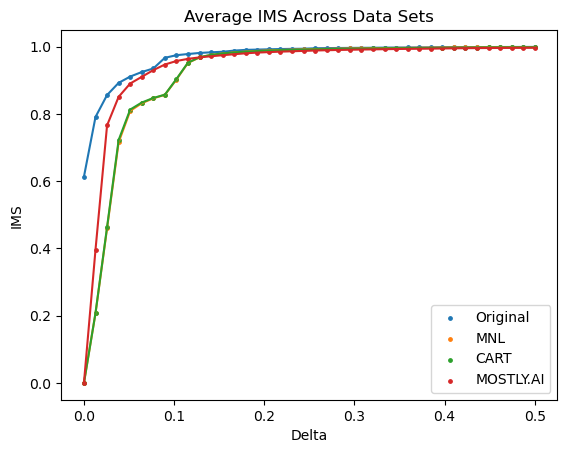

In [27]:
plt.plot(delta_vals, train_ims[0])
plt.scatter(delta_vals, train_ims, s=6, label="Original")

plt.plot(delta_vals, avg_mnl_ims)
plt.scatter(delta_vals, avg_mnl_ims, s=6, label="MNL")

# plt.plot(delta_vals, avg_ad_mnl_ims)
# plt.scatter(delta_vals, avg_ad_mnl_ims, s=6, label="AD-MNL")

plt.plot(delta_vals, avg_cart_ims)
plt.scatter(delta_vals, avg_cart_ims, s=6, label="CART")

# plt.plot(delta_vals, avg_ad_cart_ims)
# plt.scatter(delta_vals, avg_ad_cart_ims, s=6, label="AD - CART")

plt.plot(delta_vals, avg_mostly_ims)
plt.scatter(delta_vals, avg_mostly_ims, s=6, label="MOSTLY.AI")

plt.title("Average IMS Across Data Sets")
plt.xlabel("Delta")
plt.ylabel("IMS")

plt.legend()
plt.show()

***

Assess risk of attribute disclosure for `non_white`.

In [28]:
prior_non_white_prob = np.mean(train.non_white)

Create new set of deltas for attribute disclosure evaluation.

In [29]:
deltas = np.linspace(0.001, 0.5, 5)

Attribute disclosure assessment for MNL synthesized data.

In [30]:
ad_results_mnl = [attribute_disclosure_evaluation(original_data=train,
                                                  synthetic_data=Z,
                                                  continuous_vars=['incwage', 'years_of_educ', 'potential_experience'],
                                                  categorical_vars=['sex'],
                                                  sensitive_var='non_white',
                                                  prior_prob=prior_non_white_prob,
                                                  deltas=deltas) for Z in sXs_mnl]

C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


In [31]:
ad_results_mnl = [pd.concat(x, axis=1) for x in ad_results_mnl]

for i in range(20):
    ad_results_mnl[i].to_csv("../Results/IPUMS/ad_metrics_mnl_" + str(i) + ".csv", index=False)
    
ad_results_mnl = [pd.read_csv("../Results/IPUMS/ad_metrics_mnl_" + str(i) + ".csv") for i in range(20)]

Attribute disclosure assessment for AD protected MNL synthesized data.

In [32]:
# ad_results_ad_mnl = [attribute_disclosure_evaluation(original_data=train,
#                                                      synthetic_data=Z,
#                                                      continuous_vars=['latitude', 'longitude'],
#                                                      categorical_vars=['sex', 'age'],
#                                                      sensitive_var='state',
#                                                      prior_prob=prior_death_prob,
#                                                      deltas=deltas) for Z in ad_sXs_mnl]

In [33]:
# ad_results_ad_mnl = [pd.concat(x, axis=1) for x in ad_results_ad_mnl]

# for i in range(20):
#     ad_results_ad_mnl[i].to_csv("../Results/SK/ad_metrics_ad_mnl_" + str(i) + ".csv", index=False)
    
# ad_results_ad_mnl = [pd.read_csv("../Results/SK/ad_metrics_ad_mnl_" + str(i) + ".csv") for i in range(20)]

Attribute disclosure assessment for CART synthesized data.

In [34]:
ad_results_cart = [attribute_disclosure_evaluation(original_data=train,
                                                   synthetic_data=Z,
                                                   continuous_vars=['incwage', 'years_of_educ', 'potential_experience'],
                                                   categorical_vars=['sex'],
                                                   sensitive_var='non_white',
                                                   prior_prob=prior_non_white_prob,
                                                   deltas=deltas) for Z in sXs_cart]

C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


In [35]:
ad_results_cart = [pd.concat(x, axis=1) for x in ad_results_cart]

for i in range(20):
    ad_results_cart[i].to_csv("../Results/IPUMS/ad_metrics_cart_" + str(i) + ".csv", index=False)
    
ad_results_cart = [pd.read_csv("../Results/IPUMS/ad_metrics_cart_" + str(i) + ".csv") for i in range(20)]

Attribute disclosure assessment for AD protected CART synthesized data.

In [36]:
# ad_results_ad_cart = [attribute_disclosure_evaluation(original_data=train,
#                                                       synthetic_data=Z,
#                                                       continuous_vars=['latitude', 'longitude'],
#                                                       categorical_vars=['sex', 'age'],
#                                                       sensitive_var='state',
#                                                       prior_prob=prior_death_prob,
#                                                       deltas=deltas) for Z in ad_sXs_cart]

In [37]:
# ad_results_ad_cart = [pd.concat(x, axis=1) for x in ad_results_ad_cart]

# for i in range(20):
#     ad_results_ad_cart[i].to_csv("../Results/SK/ad_metrics_ad_cart_" + str(i) + ".csv", index=False)
    
# ad_results_ad_cart = [pd.read_csv("../Results/SK/ad_metrics_ad_cart_" + str(i) + ".csv") for i in range(20)]

Attribute disclosure assessment for MOSTLY.AI synthesized data.

In [39]:
ad_results_mostly = [attribute_disclosure_evaluation(original_data=train,
                                                     synthetic_data=Z,
                                                     continuous_vars=['incwage', 'years_of_educ', 'potential_experience'],
                                                     categorical_vars=['sex'],
                                                     sensitive_var='non_white',
                                                     prior_prob=prior_non_white_prob,
                                                     deltas=deltas) for Z in sXs_mostly]

C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Cameron\anaconda3\Lib\site-packages\num

Dataset completed.


In [40]:
ad_results_mostly = [pd.concat(x, axis=1) for x in ad_results_mostly]

for i in range(20):
    ad_results_mostly[i].to_csv("../Results/IPUMS/ad_metrics_mostly_" + str(i) + ".csv", index=False)
    
ad_results_mostly = [pd.read_csv("../Results/IPUMS/ad_metrics_mostly_" + str(i) + ".csv") for i in range(20)]

Calculate the maximum increase in inference in each data set for each delta value.

In [41]:
max_mnl = [np.max(x, axis=0) for x in ad_results_mnl]
# max_ad_mnl = [np.max(x, axis=0) for x in ad_results_ad_mnl]
max_cart = [np.max(x, axis=0) for x in ad_results_cart]
# max_ad_cart = [np.max(x, axis=0) for x in ad_results_ad_cart]
max_mostly = [np.max(x, axis=0) for x in ad_results_mostly]

Calculate the average of the maximum values across all synthetic data sets.

In [42]:
avg_max_mnl = np.mean(pd.concat(max_mnl, axis=1), axis=1)
# avg_max_ad_mnl = np.mean(pd.concat(max_ad_mnl, axis=1), axis=1)
avg_max_cart = np.mean(pd.concat(max_cart, axis=1), axis=1)
# avg_max_ad_cart = np.mean(pd.concat(max_ad_cart, axis=1), axis=1)
avg_max_mostly = np.mean(pd.concat(max_mostly, axis=1), axis=1)

Save the attribute disclosure risk results for plotting in R.

In [43]:
all_ad_results = pd.DataFrame({'Delta': deltas,
                               'MNL': avg_max_mnl,
                               # 'AD-MNL': avg_max_ad_mnl,
                               'CART': avg_max_cart,
                               # 'AD-CART': avg_max_ad_cart,
                               'MOSTLY.AI': avg_max_mostly})

# all_ad_results = all_ad_results.melt(id_vars=["Delta"], value_vars=["MNL", "AD-MNL", "CART", "AD-CART", "MOSTLY.AI"], var_name="Type")
all_ad_results = all_ad_results.melt(id_vars=["Delta"], value_vars=["MNL", "CART", "MOSTLY.AI"], var_name="Type")
all_ad_results.to_csv("../Results/IPUMS/all_ad_results.csv", index=False)

Plot the average (across synthetic data sets) maximum increase in attribute disclosure risk.

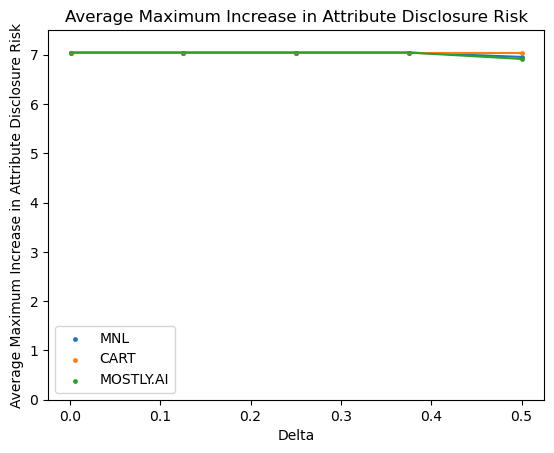

In [46]:
plt.plot(deltas, avg_max_mnl)
plt.scatter(deltas, avg_max_mnl, s=6, label="MNL")

# plt.plot(deltas, avg_max_ad_mnl)
# plt.scatter(deltas, avg_max_ad_mnl, s=6, label="AD - MNL")

plt.plot(deltas, avg_max_cart)
plt.scatter(deltas, avg_max_cart, s=6, label="CART")

# plt.plot(deltas, avg_max_ad_cart)
# plt.scatter(deltas, avg_max_ad_cart, s=6, label="AD - CART")

plt.plot(deltas, avg_max_mostly)
plt.scatter(deltas, avg_max_mostly, s=6, label="MOSTLY.AI")

plt.title("Average Maximum Increase in Attribute Disclosure Risk")
plt.xlabel("Delta")
plt.ylabel("Average Maximum Increase in Attribute Disclosure Risk")

plt.ylim(0, 7.5)

plt.legend()
plt.show()